## Import standard packages

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models       

## Load, Visualize and Prepare Data

### In this step, we load the dataset, examine its structure, and prepare it for model traning

#### Load the dataset containing Apple stock data

In [3]:
df = pd.read_csv("BATS_AAPL, 60 clean.csv")
df.head()

,time,open,high,low,close,Basis,Upper,Lower,EMA,Volume,Plot,RSI,RSI-based MA,Upper Bollinger Band,Lower Bollinger Band,Histogram,MACD,Signal
0,2018-01-02T08:00:00-05:00,42.54250,42.5425,42.54250,42.5425,NaN,NaN,NaN,NaN,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02T09:00:00-05:00,42.52500,42.7675,42.31750,42.7500,NaN,NaN,NaN,NaN,980356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02T10:00:00-05:00,42.74375,42.9000,42.71500,42.8725,NaN,NaN,NaN,NaN,1181796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-02T11:00:00-05:00,42.87500,42.8800,42.77625,42.8025,NaN,NaN,NaN,NaN,540808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-02T12:00:00-05:00,42.80250,42.8750,42.80000,42.8200,NaN,NaN,NaN,NaN,401980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Convert the 'time' column to datetime format and set it as the index for easier time-series analysis
df['time'] = pd.to_datetime(df['time'], utc=True)
df.set_index('time', inplace=True)

In [5]:
# Calculating Price Change to determine direction and magnitude
df['Price_Change'] = df['close'].diff()

In [6]:
# 'Direction' represents whether the price increased (1) or decreased (0)
df['Direction'] = np.where(df['Price_Change'] > 0, 1, 0)

In [7]:
# 'Magnitude' represents the absolute size of the price change
df['Magnitude'] = df['Price_Change'].abs()

In [8]:
# Creating Lag Features for tracking previous price trends
df['Lag_1'] = df['close'].shift(1)
df['Lag_2'] = df['close'].shift(2)

In [9]:
# Adding Moving Averages for trend analysis
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean()

In [10]:
# RSI (Relative Strength Index) Calculation for overbought/oversold conditions
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [11]:
# Volatility Calculation using rolling standard deviation (used for risk analysis)
df['Volatility'] = df['close'].rolling(window=20).std()

### Data Cleaning ###

In [12]:
df = df.dropna(subset=[
    'Magnitude','Lag_1','Lag_2','SMA_10','SMA_20','EMA_10','RSI','Volatility'
])

In [13]:
# Drop columns that are entirely NaN
df.drop(['Upper Bollinger Band', 'Lower Bollinger Band', 'Plot'], axis=1, inplace=True)

# Forward fill for smoother data continuity
df.fillna(method='ffill', inplace=True)

# Fill any remaining NaN values with zero
df.fillna(0, inplace=True)

# Verify data quality
print(f"Cleaned Dataset Shape: {df.shape}")
print(df.head(10))
print("\nRemaining Missing Values:")


Cleaned Dataset Shape: (21257, 23)
                              open     high       low    close      Basis  \
time                                                                        
2018-01-04 16:00:00+00:00  43.2375  43.3650  43.19000  43.2575  43.082813   
2018-01-04 17:00:00+00:00  43.2575  43.3025  43.16500  43.2075  43.116062   
2018-01-04 18:00:00+00:00  43.2075  43.2325  43.15000  43.2325  43.140188   
2018-01-04 19:00:00+00:00  43.2325  43.2950  43.21250  43.2800  43.160562   
2018-01-04 20:00:00+00:00  43.2825  43.3075  43.23875  43.2475  43.182812   
2018-01-04 21:00:00+00:00  43.2700  43.2700  43.27000  43.2700  43.205312   
2018-01-05 12:00:00+00:00  43.3375  43.3375  43.33750  43.3375  43.226188   
2018-01-05 13:00:00+00:00  43.3750  43.4350  43.37500  43.4350  43.248125   
2018-01-05 14:00:00+00:00  43.3550  43.5450  43.26500  43.5225  43.271125   
2018-01-05 15:00:00+00:00  43.5325  43.7975  43.44750  43.7825  43.308750   

                               Upper    

C:\Users\kenny\AppData\Local\Temp\ipykernel_20496\3454248568.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [14]:
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='any')
print("Post‐clean shape:", df.shape)
print("Any NaNs left?:", df.isna().sum().sum())

Post‐clean shape: (21257, 23)
Any NaNs left?: 0


In [15]:
# Verifying data quality
print(f"Cleaned Dataset Shape: {df.shape}")
print(df.head(10))
print("\nRemaining Missing Values:")
print(df.isna().sum())

Cleaned Dataset Shape: (21257, 23)
                              open     high       low    close      Basis  \
time                                                                        
2018-01-04 16:00:00+00:00  43.2375  43.3650  43.19000  43.2575  43.082813   
2018-01-04 17:00:00+00:00  43.2575  43.3025  43.16500  43.2075  43.116062   
2018-01-04 18:00:00+00:00  43.2075  43.2325  43.15000  43.2325  43.140188   
2018-01-04 19:00:00+00:00  43.2325  43.2950  43.21250  43.2800  43.160562   
2018-01-04 20:00:00+00:00  43.2825  43.3075  43.23875  43.2475  43.182812   
2018-01-04 21:00:00+00:00  43.2700  43.2700  43.27000  43.2700  43.205312   
2018-01-05 12:00:00+00:00  43.3375  43.3375  43.33750  43.3375  43.226188   
2018-01-05 13:00:00+00:00  43.3750  43.4350  43.37500  43.4350  43.248125   
2018-01-05 14:00:00+00:00  43.3550  43.5450  43.26500  43.5225  43.271125   
2018-01-05 15:00:00+00:00  43.5325  43.7975  43.44750  43.7825  43.308750   

                               Upper    

### Visualizations

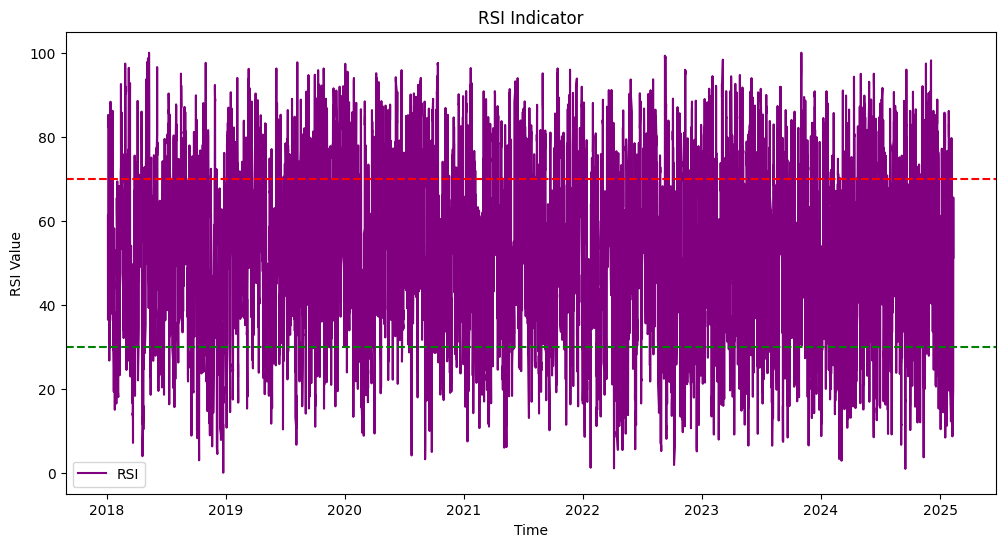

In [16]:
# RSI Indicator Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')  # Overbought Level
plt.axhline(30, color='green', linestyle='--')  # Oversold Level
plt.title("RSI Indicator")
plt.xlabel("Time")
plt.ylabel("RSI Value")
plt.legend()
plt.show()

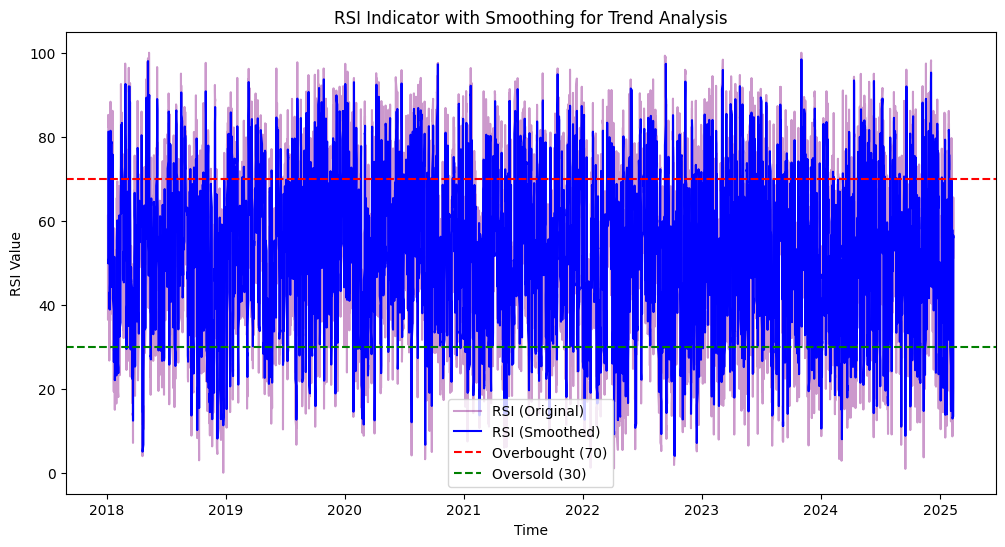

In [17]:
# Smooth RSI using a 7-period Moving Average
df['RSI_Smooth'] = df['RSI'].rolling(window=7).mean()

# Visualize Smoothed RSI
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], label='RSI (Original)', alpha=0.4, color='purple')
plt.plot(df['RSI_Smooth'], label='RSI (Smoothed)', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title("RSI Indicator with Smoothing for Trend Analysis")
plt.xlabel("Time")
plt.ylabel("RSI Value")
plt.legend()
plt.show()


The RSI chart highlights significant volatility, with frequent spikes indicating rapid momentum shifts. The RSI frequently crosses the 70 (overbought) and 30 (oversold) thresholds, which are key signals for potential trend reversals. However, the densely packed data points make it challenging to identify clear trends at a glance.

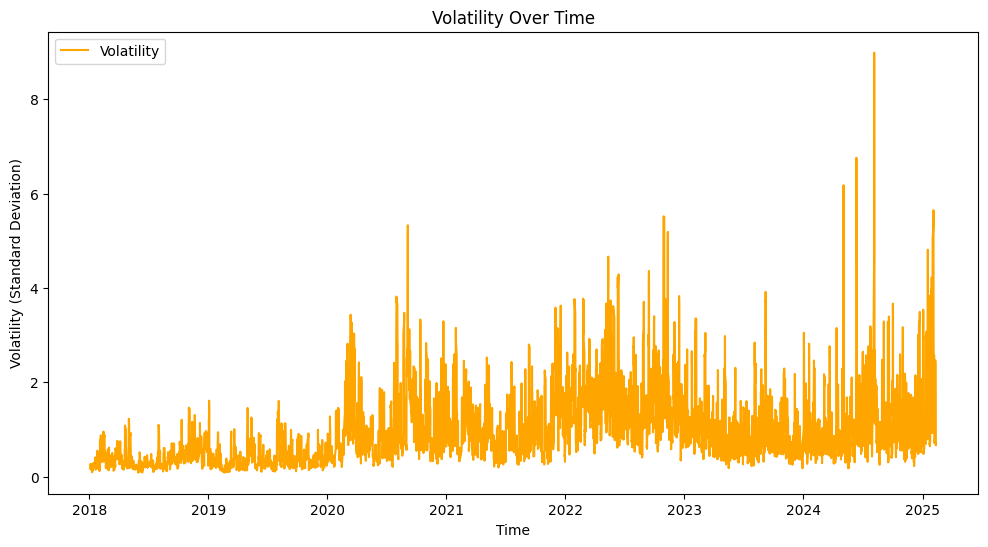

In [18]:
# Volatility Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['Volatility'], label='Volatility', color='orange')
plt.title("Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Volatility (Standard Deviation)")
plt.legend()
plt.show()

The volatility chart reveals fluctuating market behavior over time, with noticeable spikes indicating periods of heightened uncertainty. These volatility surges are critical for AI models predicting direction and magnitude of stock price changes. Higher volatility often signals potential trend reversals or larger price swings, while lower volatility suggests more stable price movement.

Incorporating this volatility data into an AI model can improve predictions by helping it adjust for rapid market shifts, enhancing both trend direction accuracy and movement magnitude forecasting.

## Handle Missing Data

#### Remove any remaining NaNs to ensure the dataset is clean and ready for modeling.

In [62]:
feature_cols = [c for c in df.columns if c != 'Next_Close']
df['Next_Close'] = df['close'].shift(-1)

In [63]:
df = df.dropna(axis=0, how='any')

In [64]:
X = df[feature_cols].values
y = df['Next_Close'].values

## We split the dataset into training and testing sets.

#### We also reshape and scale the data if needed to to match the model input shape.

In [65]:
# Split the data into training and test sets (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [66]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 30
X_tr, y_tr = create_sequences(X_train, y_train, SEQ_LEN)
X_te, y_te = create_sequences(X_test,  y_test,  SEQ_LEN)


## Define the Transformer Model

#### Key components include:
#### - Positional Encoding layer 
#### - Multi-Head Attention
#### - Feedforward Dense layers
#### - Dropout layers to reduce overfitting

In [74]:
from tensorflow.keras.optimizers import Adam

#  the Transformer model
def build_transformer_model(input_shape, d_model=64, n_heads=4):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding 
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)

    pos = tf.range(start=0, limit=SEQ_LEN, delta=1)
    pos_emb = layers.Embedding(input_dim=SEQ_LEN, output_dim=d_model)(pos)
    x = x + pos_emb 

    # Multi-Head Attention Layer
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network
    x = layers.Dense(64, activation="relu")(x)
    x = x[:, -1, :] 

    # Output layer
    outputs = layers.Dense(1)(x)  

    # Build model
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

n_feats  = X_tr.shape[2]    
SEQ_LEN  = 30
model    = build_transformer_model((SEQ_LEN, n_feats), d_model=64, n_heads=4)
model.summary()        

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 30, 24)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 30, 64)            │           4,672 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 30, 64)            │               0 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_2        │ (None, 30, 64)            │          33,216 │ add_4[0][0], add_4[0][0]   │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 30, 64)            │             128 │ multi_head_attention_2[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 30, 64)            │           4,160 │ layer_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 64)                │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 1)                 │              65 │ get_item_1[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 42,241 (165.00 KB)

 Trainable params: 42,241 (165.00 KB)

 Non-trainable params: 0 (0.00 B)

### Sanity Check for the NaNs

In [94]:
print("X_tr NaNs:", np.isnan(X_tr).sum(), " Infs:", np.isinf(X_tr).sum())
print("y_tr NaNs:", np.isnan(y_tr).sum(), " Infs:", np.isinf(y_tr).sum())

X_tr NaNs: 0  Infs: 0
y_tr NaNs: 0  Infs: 0


In [95]:
X_tr = np.nan_to_num(X_tr, nan=0.0, posinf=1e6, neginf=-1e6)
X_te = np.nan_to_num(X_te, nan=0.0, posinf=1e6, neginf=-1e6)

In [96]:
from sklearn.preprocessing import StandardScaler
n_train, seq_len, nfeat = X_tr.shape
n_test  = X_te.shape[0]

# flatten
X_tr_flat = X_tr.reshape(-1, nfeat)
X_te_flat = X_te.reshape(-1, nfeat)

# fit & transform
scaler = StandardScaler().fit(X_tr_flat)
X_tr = scaler.transform(X_tr_flat).reshape(n_train, seq_len, nfeat)
X_te = scaler.transform(X_te_flat).reshape(n_test,  seq_len, nfeat)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
  EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
  ModelCheckpoint("best_model.h5", save_best_only=True)
]

## Fit the model

In [86]:
history = model.fit(
    X_tr, y_tr, 
    validation_data=(X_te, y_te),
    epochs=20, batch_size=32,
    callbacks = callbacks,
)
print("Test MAE:", model.evaluate(X_te, y_te, verbose=0)[1])

Epoch 1/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8973 - mae: 0.6818 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.8973 - mae: 0.6818 - val_loss: 674.7132 - val_mae: 18.2656 - learning_rate: 1.2500e-04
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9703 - mae: 0.7212 

531/531 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.9703 - mae: 0.7212 - val_loss: 642.2286 - val_mae: 17.8329 - learning_rate: 1.2500e-04
Epoch 3/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9168 - mae: 0.6900 

531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.9167 - mae: 0.6899 - val_loss: 617.3145 - val_mae: 17.5295 - learning_rate: 1.2500e-04
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.8723 - mae: 0.6763 - val_loss: 637.2136 - val_mae: 17.7448 - learning_rate: 1.2500e-04
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.9358 - mae: 0.6833 - val_loss: 634.9899 - val_mae: 17.7944 - learning_rate: 1.2500e-04
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.9124 - mae: 0.6886 - val_loss: 634.6982 - val_mae: 17.6484 - learning_rate: 1.2500e-04
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.8443 - mae: 0.6495 - val_loss: 645.5466 - val_mae: 17.7632 - learning_rate: 6.2500e-05
Epoch 8/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7990 - mae: 0.6321 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.7991 - mae: 0.6321 - val_loss: 607.5291 - val_mae: 17.3140 - learning_rate: 6.2500e-05
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.8444 - mae: 0.6451 - val_loss: 624.6014 - val_mae: 17.4685 - learning_rate: 6.2500e-05
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.8365 - mae: 0.6514 - val_loss: 627.8440 - val_mae: 17.4944 - learning_rate: 6.2500e-05
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.8442 - mae: 0.6573 - val_loss: 608.0734 - val_mae: 17.2604 - learning_rate: 6.2500e-05
Epoch 12/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8046 - mae: 0.6256 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.8044 - mae: 0.6255 - val_loss: 602.6619 - val_mae: 17.2053 - learning_rate: 3.1250e-05
Epoch 13/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 0.7574 - mae: 0.6141 - val_loss: 610.6993 - val_mae: 17.2424 - learning_rate: 3.1250e-05
Epoch 14/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.7809 - mae: 0.6284 - val_loss: 605.2944 - val_mae: 17.1804 - learning_rate: 3.1250e-05
Epoch 15/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8054 - mae: 0.6333 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.8053 - mae: 0.6332 - val_loss: 600.4214 - val_mae: 17.1369 - learning_rate: 3.1250e-05
Epoch 16/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7645 - mae: 0.6193 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.7646 - mae: 0.6193 - val_loss: 598.0670 - val_mae: 17.0632 - learning_rate: 3.1250e-05
Epoch 17/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8054 - mae: 0.6280 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.8053 - mae: 0.6280 - val_loss: 591.6187 - val_mae: 16.9948 - learning_rate: 3.1250e-05
Epoch 18/20
529/531 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7839 - mae: 0.6212 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.7838 - mae: 0.6212 - val_loss: 591.1339 - val_mae: 16.9614 - learning_rate: 3.1250e-05
Epoch 19/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7644 - mae: 0.6169 

531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.7644 - mae: 0.6169 - val_loss: 583.3424 - val_mae: 16.9268 - learning_rate: 3.1250e-05
Epoch 20/20
530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7825 - mae: 0.6270 

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.7824 - mae: 0.6270 - val_loss: 572.1517 - val_mae: 16.7784 - learning_rate: 3.1250e-05
Test MAE: 16.77842140197754


132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


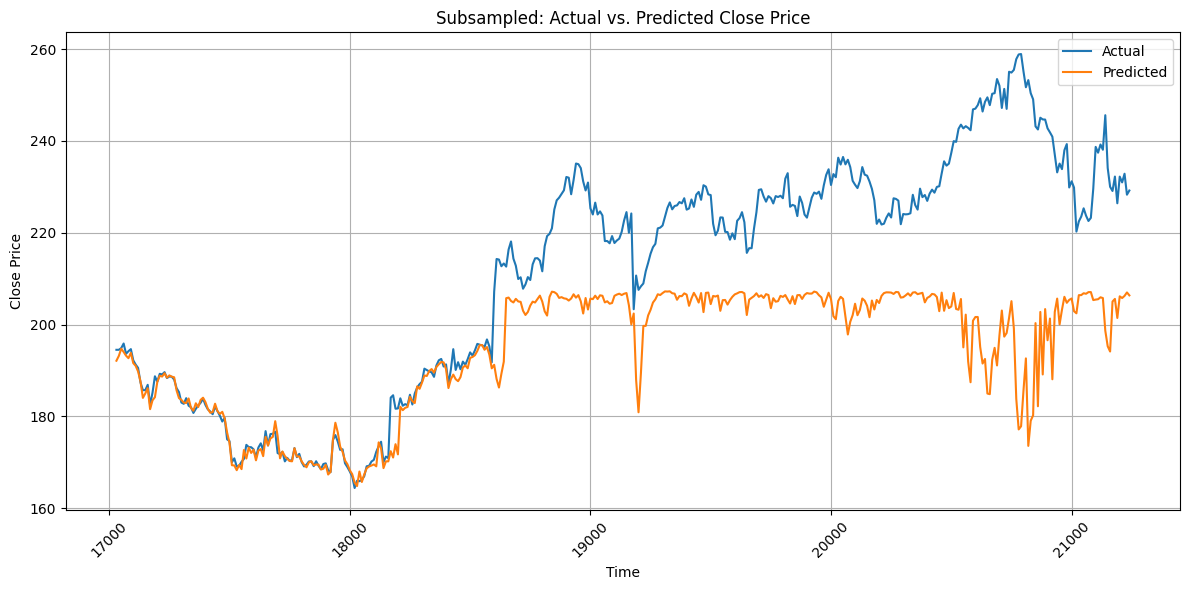

In [101]:
# predictions
y_pred = model.predict(X_te)        
y_pred = y_pred.flatten() 


test_idx = df.iloc[-len(y_te):].index   
pred_df = pd.DataFrame({
    'actual': y_te,
    'predicted': y_pred
}, index=test_idx)

## Something was glitching in my notebook whenever i tried to plot the graph so i tried to subsample it 
pred_df_small = pred_df.iloc[::10]

plt.figure(figsize=(12, 6))
plt.plot(pred_df_small.index, pred_df_small['actual'],    label='Actual')
plt.plot(pred_df_small.index, pred_df_small['predicted'], label='Predicted')
plt.xlabel('Time'); plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend(); plt.grid(True); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("First 10 predictions:", y_pred[:10])

#Compute metrics against the true test values
mae = mean_absolute_error(y_te, y_pred)
mse = mean_squared_error(y_te, y_pred)
r2  = r2_score(y_te, y_pred)

print(f"Mean Absolute Error (MAE):  {mae:.4f}")
print(f"Mean Squared Error (MSE):   {mse:.4f}")
print(f"R-Squared (R²):             {r2:.4f}")

# Compute RMSE for your magnitude predictions
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
print(f"Magnitude Prediction RMSE: {rmse:.2f}")

First 10 predictions: [192.11072 192.60548 193.13611 192.73215 192.78638 192.9115  193.35452
 192.97711 193.0192  193.24518]
Mean Absolute Error (MAE):  16.7784
Mean Squared Error (MSE):   572.1518
R-Squared (R²):             0.1174
Magnitude Prediction RMSE: 23.92


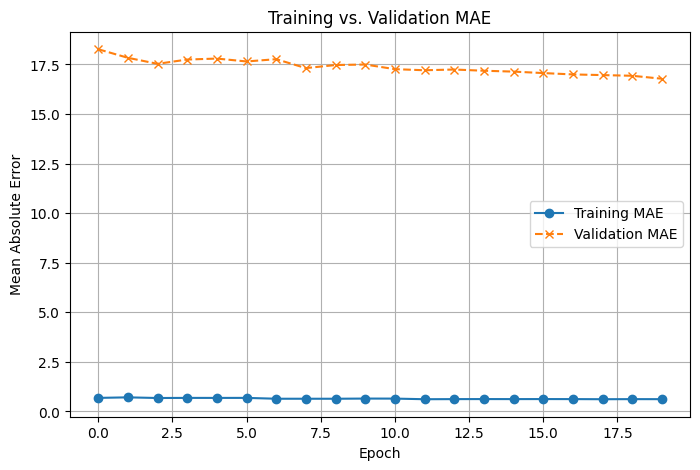

In [103]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["mae"],       label="Training MAE",   marker="o")
if "val_mae" in history.history:
    plt.plot(history.history["val_mae"], label="Validation MAE", linestyle="--", marker="x")

plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs. Validation MAE")
plt.legend()
plt.grid(True)
plt.show()

## Hyper Parameter Tuning

#### Use `keras_tuner` to optimize key parameters such as:
#### - Number of attention heads
#### - Model depth
#### - Learning rate
#### - Dropout rate

#### This helps in finding a model that generalizes better on unseen data.

In [104]:
import keras_tuner as kt
SEQ_LEN = 30
n_feats = X_tr.shape[2]  

# Build a tunable model
def build_tunable_transformer(hp):

    d_model    = hp.Choice("d_model",     [32, 64, 128]) # size of the vector space for embeddings
    num_heads  = hp.Choice("num_heads",   [2, 4, 8])  # number of attentions heads
    ff_dim     = hp.Choice("ff_dim",      [64, 128, 256]) #size of the feed-fowrd layers
    num_layers = hp.Int(   "num_layers",  1, 3, step=1) # Number of encoder blocks
    dropout    = hp.Float( "dropout",     0.0, 0.3, step=0.1) # Dropout rate to avoid overfitting
    lr         = hp.Float( "learning_rate", 1e-4, 1e-2, sampling="log") # Learning rate for the Adam optimizer
    
    # Input
    inputs = layers.Input(shape=(SEQ_LEN, n_feats))
    x = layers.Dense(d_model)(inputs)
    
    # Positional embeddings
    pos      = tf.range(start=0, limit=SEQ_LEN, delta=1)
    pos_emb  = layers.Embedding(input_dim=SEQ_LEN, output_dim=d_model)(pos)
    x       += pos_emb
    
    # Encoder blocks
    for _ in range(num_layers):
        # Self‐attention
        attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )(x, x)
        attn = layers.Dropout(dropout)(attn)
        x = layers.LayerNormalization()(x + attn)
        
        # Feed-forward
        ffn = layers.Dense(ff_dim, activation="relu")(x)
        ffn = layers.Dropout(dropout)(ffn)
        ffn = layers.Dense(d_model)(ffn)
        x = layers.LayerNormalization()(x + ffn)
    
    # Take last token, regression head
    x = layers.Lambda(lambda t: t[:, -1, :])(x)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=lr, clipnorm=1.0),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [125]:
# Instantiate the tuner changed from Bayeisan/Hyperband for speed 
tuner = kt.RandomSearch(
    build_tunable_transformer,      
    objective="val_mae",           
    max_trials=80,                   
    executions_per_trial=1,         
    directory="random_tuning",      
    project_name="ts_transformer_ta"
)


Reloading Tuner from random_tuning\ts_transformer_ta\tuner0.json


In [ ]:
# Run the search
tuner.search(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=10,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]
)

Trial 77 Complete [00h 11m 33s]
val_mae: 22.984037399291992

Best val_mae So Far: 15.758652687072754
Total elapsed time: 18h 54m 14s

Search: Running Trial #78

Value             |Best Value So Far |Hyperparameter
32                |128               |d_model
4                 |8                 |num_heads
128               |256               |ff_dim
1                 |1                 |num_layers
0.1               |0                 |dropout
0.00013492        |0.0025926         |learning_rate

Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - loss: 15711.2930 - mae: 114.4156 - val_loss: 40843.8711 - val_mae: 200.4886
Epoch 2/10
 19/531 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 14757.3164 - mae: 109.9324 

In [118]:
# Retrieve best hyperparameters and model
best_hp    = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

C:\Users\kenny\miniconda3\envs\ai_ai\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [119]:
print("Best hyperparameters:")
print(f"  d_model:     {best_hp.get('d_model')}")
print(f"  num_heads:   {best_hp.get('num_heads')}")
print(f"  ff_dim:      {best_hp.get('ff_dim')}")
print(f"  num_layers:  {best_hp.get('num_layers')}")
print(f"  dropout:     {best_hp.get('dropout'):.2f}")
print(f"  learning_rate: {best_hp.get('learning_rate'):.1e}")

Best hyperparameters:
  d_model:     128
  num_heads:   8
  ff_dim:      256
  num_layers:  1
  dropout:     0.00
  learning_rate: 2.6e-03


In [120]:
# Predict on the test windows
y_pred = best_model.predict(X_te).flatten()

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


In [121]:
print("First 10 after hyperparameters predictions:", y_pred[:10])
mae  = mean_absolute_error(y_te, y_pred)
mse  = mean_squared_error(y_te, y_pred)
r2   = r2_score(y_te, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {mse**0.5:.4f}")
print(f"Test R²:  {r2:.4f}")

First 10 after hyperparameters predictions: [193.85086 194.17023 194.39598 193.05196 193.14575 193.41168 193.64626
 194.41812 193.4952  192.6002 ]
Test MAE: 15.4944
Test RMSE: 20.5420
Test R²:  0.3490


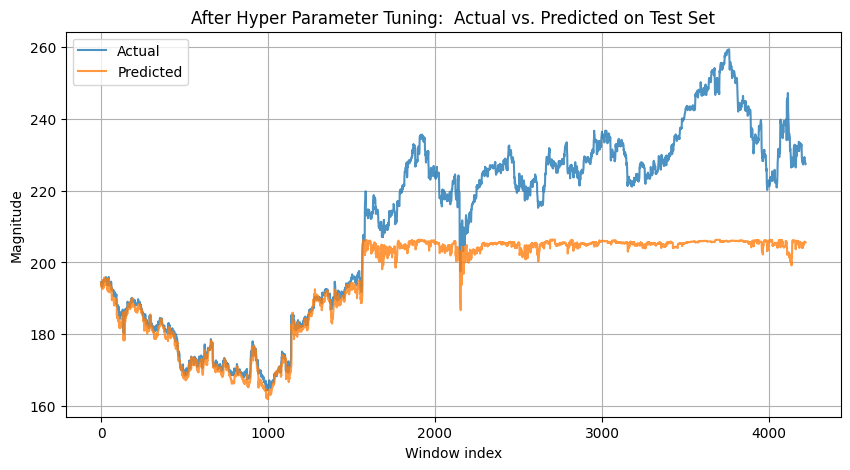

In [124]:
plt.figure(figsize=(10,5))
plt.plot(y_te,   label="Actual", alpha=0.8)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.legend()
plt.title("After Hyper Parameter Tuning:  Actual vs. Predicted on Test Set")
plt.xlabel("Window index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()